# 12. A/B testing - maternal smoking & birth weight

In this example, we have a dataset called births containing information about mother-baby pairs, such as birth weight, gestational days, maternal age, maternal height, pregnancy weight, and whether the mother smoked during pregnancy. We're particularly interested in the relationship between maternal smoking and birth weight.

In [147]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

births = pd.read_csv('baby.csv')
births.head()

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
4,136,286,25,62,93,False



## 1. Smokers and Nonsmokers

We start by selecting the columns 'Maternal Smoker' and 'Birth Weight' and grouping the data based on maternal smoking status:

In [7]:
smoking_and_birthweight = births.groupby('Maternal Smoker')['Birth Weight'].count().reset_index()
smoking_and_birthweight

,Maternal Smoker,Birth Weight
0,False,715
1,True,459


This shows that there are 715 non-smokers and 459 smokers in the sample.

Next, we visualise the distribution of birth weights for non-smokers and smokers using overlaid histograms:

<Axes: xlabel='Birth Weight', ylabel='Count'>

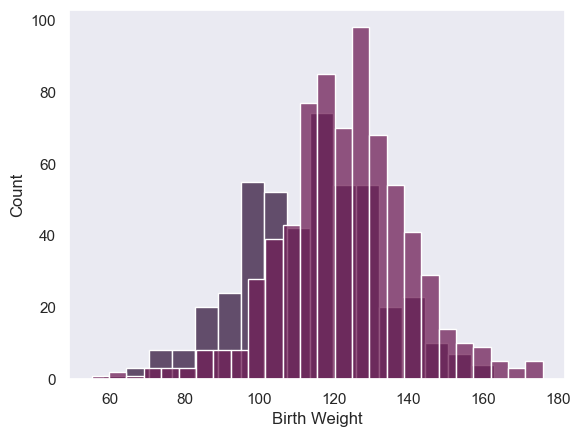

In [75]:
sns.set(style="dark")
sns.set_palette('rocket')

maternal_smoker_true = births[births['Maternal Smoker'] == True]
sns.histplot(maternal_smoker_true['Birth Weight'])

maternal_smoker_false = births[births['Maternal Smoker'] == False]
sns.histplot(maternal_smoker_false['Birth Weight'])

The histograms suggest that the birth weights of babies born to smoking mothers might be slightly lower on average compared to non-smoking mothers.

## 2. The Hypotheses

We want to test whether the observed difference is due to chance or if it reflects an actual difference in the population. We set up two hypotheses:

Null Hypothesis: The birth weight distribution is the same for babies of smoking and non-smoking mothers. Any observed difference is due to chance.

Alternative Hypothesis: Babies of smoking mothers have a lower birth weight, on average, compared to babies of non-smoking mothers.

## 3. Test Statistic

We use the difference between the average birth weights of the two groups as our test statistic. The observed difference is calculated from the sample.

In [122]:
observed_difference = maternal_smoker_true['Birth Weight'].mean() - maternal_smoker_false['Birth Weight'].mean()

The test statistic is the difference between the average birth weight of the smoking group and the average birth weight of the non-smoking group. Small values (large negative values) of this statistic support the alternative hypothesis.

We are going compute such differences repeatedly in our simulations below, so we will define a function to do the job. The function takes two arguments:
* the name of the table of data
* the label of the column that contains the Boolean variable for grouping

It returns the difference of 'Birth Weight' between the means of the True group and the False group. 

In [76]:
def difference_of_mean(dataset, group_column):
    """Takes: DataFrame,
    column label that indicates the group to which the row belongs
    Returns: Difference of mean birth weights of the two groups"""
    means = dataset.groupby(group_column)['Birth Weight'].mean()
    return [True] - [False]

Tests:

In [77]:
difference_of_means(births, 'Maternal Smoker')

-9.266142572024918

## 4. Simulation
To simulate the statistic under the null hypothesis, a clever method involving random permutations is used. The idea is to shuffle all the labels randomly among the mothers, ensuring that the counts of True and False labels do not change.

### 4.1. Shuffling Labels:
The original data is used, and the labels in the 'Maternal Smoker' column are shuffled randomly. This is done by drawing a random sample without replacement using the sample method:

In [94]:
births_subset = births[['Birth Weight', 'Maternal Smoker']].copy()
births_subset['Shuffled Maternal Smoker'] = births['Maternal Smoker'].sample(frac=1).reset_index(drop=True)
births_subset

,Birth Weight,Maternal Smoker,Shuffled Maternal Smoker
0,120,False,False
1,113,False,True
2,128,True,False
3,108,True,True
4,136,False,True
...,...,...,...
1169,113,False,False
1170,128,False,False
1171,130,True,False
1172,125,False,True


### 4.2. Calculating Group Means with Shuffled Labels:
Each baby’s mother now has a random smoker/non-smoker label in the column Shuffled Label, while her original label is in Maternal Smoker. If the null hypothesis is true, all the random re-arrangements of the labels should be equally likely.

The average weights for the two groups with shuffled labels are calculated:

In [95]:
shuffledsmoking_and_birthweight = births_subset.groupby('Shuffled Maternal Smoker')['Birth Weight'].mean().reset_index()
shuffledsmoking_and_birthweight

,Shuffled Maternal Smoker,Birth Weight
0,False,119.353846
1,True,119.631808


In [96]:
difference_of_means(births_subset, 'Shuffled Maternal Smoker')

0.27796212502094875

The resulting averages are closer than the averages of the two original groups, as expected. However since we used shuffling above, each time the outcome is different. Thus, we wanna see the dist of diff of means across many simulations.

### 4.3. Simulating Many Differences:
To understand the variability, the process is simulated many times. A function, one_simulated_difference_of_means, is defined to simulate one value of the test statistic under the null hypothesis. Basically we repeat the above but now we put it into a complete function:

,Simulation,Difference of mean
0,1,0.932599
1,2,-2.129528
2,3,-0.759441
3,4,0.370971
4,5,0.449670


<Axes: xlabel='Difference of mean', ylabel='Count'>

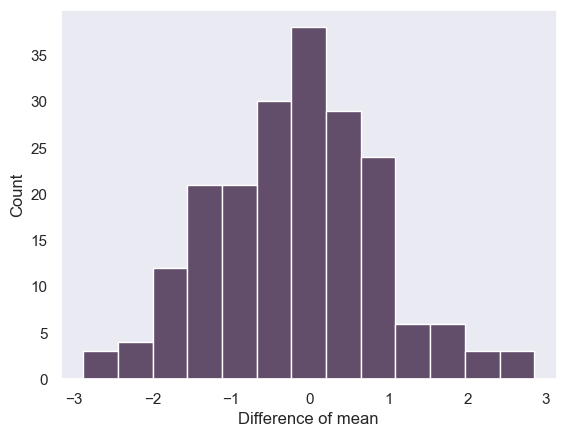

In [154]:
def simulated_difference_of_means(dataset):
    """Returns: Difference between mean birthweights of babies of smokers and non-smokers after shuffling labels n times"""
    data = []
    for i in range(1, rep + 1):
        # Shuffling
        dataset['Shuffled Maternal Smoker'] = dataset['Maternal Smoker'].sample(frac=1).reset_index(drop=True)
        # Find dim
        dim = difference_of_means(dataset, 'Shuffled Maternal Smoker')
        # Update to results table
        data.append({
            'Simulation': i,
            'Difference of mean': dim
        })
    df_data = pd.DataFrame(data)
    return df_data


rep = int(input('Enter the number of repetitions: '))

df_data = simulated_difference_of_means(births_subset)
display(df_data.head())

# plot
sns.histplot(data = df_data, x = 'Difference of mean')

Notice how the distribution is centered roughly around 0. This makes sense, because under the null hypothesis the two groups should have roughly the same average. Therefore the difference between the group averages should be around 0.

The observed difference in the original sample is about 9.27 ounces, which doesn’t even appear on the horizontal scale of the histogram. The observed value of the statistic and the predicted behavior of the statistic under the null hypothesis are inconsistent.

The conclusion of the test is that the data **favours the alternative over the null**. It supports the hypothesis that the average birth weight of babies born to mothers who smoke is less than the average birth weight of babies born to non-smokers.

## 5. Empirical p-value for inferential

In [157]:
observed_dim = difference_of_means(births, 'Maternal Smoker')

p = np.count_nonzero(df_data['Difference of mean'] <= observed_dim) / rep
p

0.0

The empirical p-value is 0, meaning that none of the 5,000 permuted samples resulted in a difference of -9.27 or lower. This is only an approximation. The exact chance of getting a difference in that range is not 0. But it is vanishingly small, according to our simulation, and therefore we can reject the null hypothesis.

## 6. Same shit for other predictors aside from Smoking status

The difference is that the other are numerical, not boolean like Smoking stat (technically regression straightup would be better than comparison of means). To see why, rmb that you calc the difference of means between the different groups. Unless you group the ppl into diff weight groups, there's gonna be no groups but rather a continuous scale of weights.